In [29]:
# Linear Regression wwith OLS
import statsmodels.api as sm

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Step #1: Read Data

In [30]:
# Read data
df = pd.read_csv('../../../Dataset/BTC-USD.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...,...
2280,2024-05-28,69392.195313,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
2281,2024-05-29,68296.351563,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
2282,2024-05-30,67576.085938,69500.539063,67118.078125,68364.992188,68364.992188,29509712534
2283,2024-05-31,68362.515625,68999.562500,66633.421875,67491.414063,67491.414063,27387283769


# Step #2: Explore the Data

In [31]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")


Dataset Shape: (2285, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2285 entries, 2018-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2285 non-null   float64
 1   High       2285 non-null   float64
 2   Low        2285 non-null   float64
 3   Close      2285 non-null   float64
 4   Adj Close  2285 non-null   float64
 5   Volume     2285 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.0 KB
Dataset Info: None
Dataset Describe:                Open          High           Low         Close     Adj Close  \
count   2285.000000   2285.000000   2285.000000   2285.000000   2285.000000   
mean   24460.039968  25010.063700  23873.494115  24483.298446  24483.298446   
std    18234.366115  18677.832579  17742.882905  18251.603919  18251.603919   
min     3236.274658   3275.377930   3191.303467   3236.761719   3236.761719   
25%     8603.428711   8755.852539   8374.323242

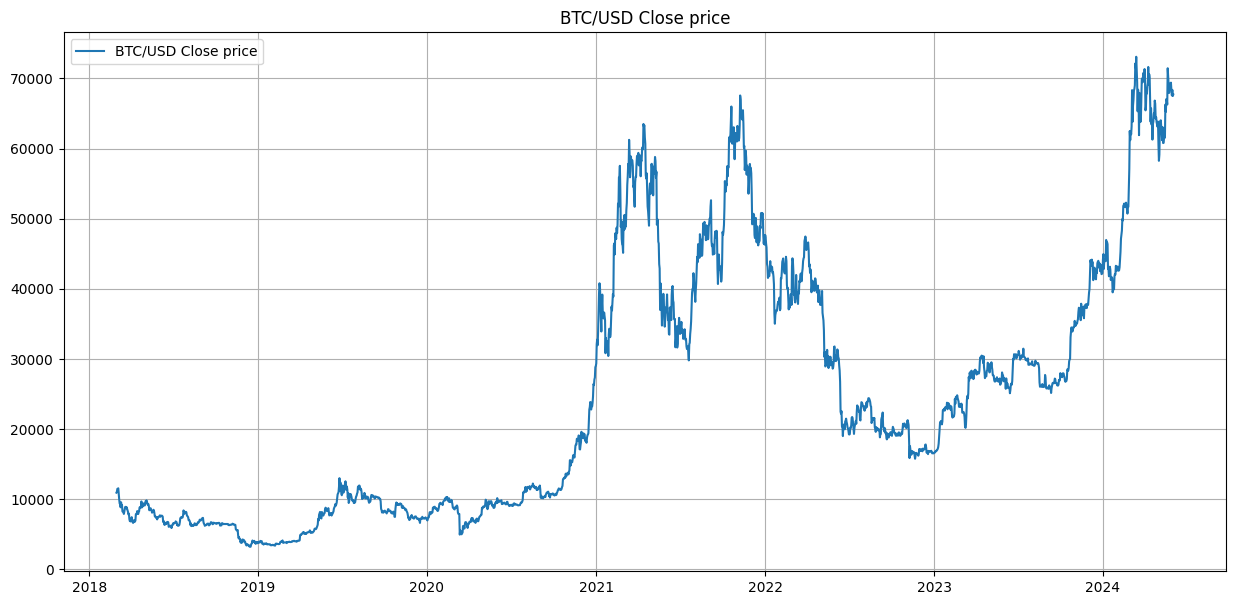

In [32]:
# Plotting data
plt.style.use('default')
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='BTC/USD Close price')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()



# Step #3: Feature Engineering

In [33]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                   Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                                                                                 
2024-05-28  68296.218750   1513.737899             72908.442357             58875.404127  65125.811749   66876.859258
2024-05-29  67578.093750   1432.292774             72974.761404             59519.912815  65478.611178   67012.036352
2024-05-30  68364.992188   1294.873741             73051.203319             59896.284182  65658.928786   67065.946581
2024-05-31  67491.414063   1235.225386             72903.637919             60801.071066  65830.987230   67189.665210
2024-06-01  67706.937500   1104.728558             72526.151854             61848.327443  65964.074970   67218.403196
                  Close  MACD_shift-1  Bollinger_Upper_shift-1  Bollinger_Lower_shift-1  MA26_shift-1  EMA20_shift-1
Date                                                     

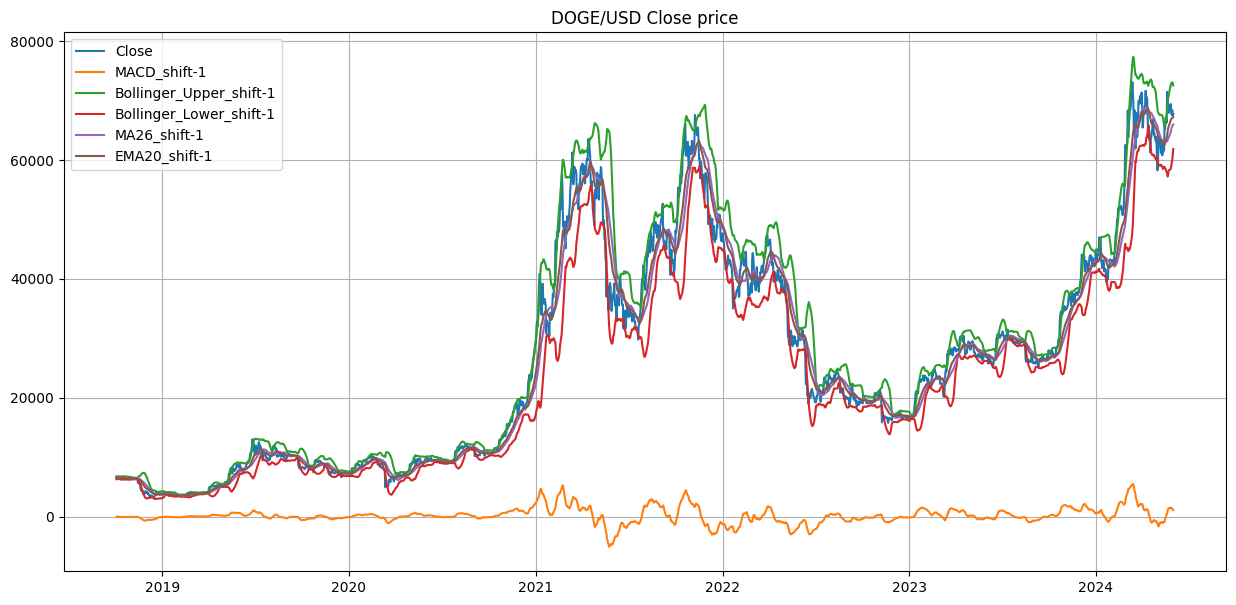

In [34]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

df_original = df_filtered.copy()

# Create shifted features
for feature in FEATURES:
    if feature != 'Close':
        df_filtered[feature + '_shift-1'] = df_filtered[feature].shift(1)
        df_filtered = df_filtered.drop(feature, axis=1)

df_filtered = df_filtered.dropna()


print(df_filtered.tail().to_string())
print(df_filtered.head().to_string())
print(df_original.head().to_string())
print(df_original.tail().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('DOGE/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


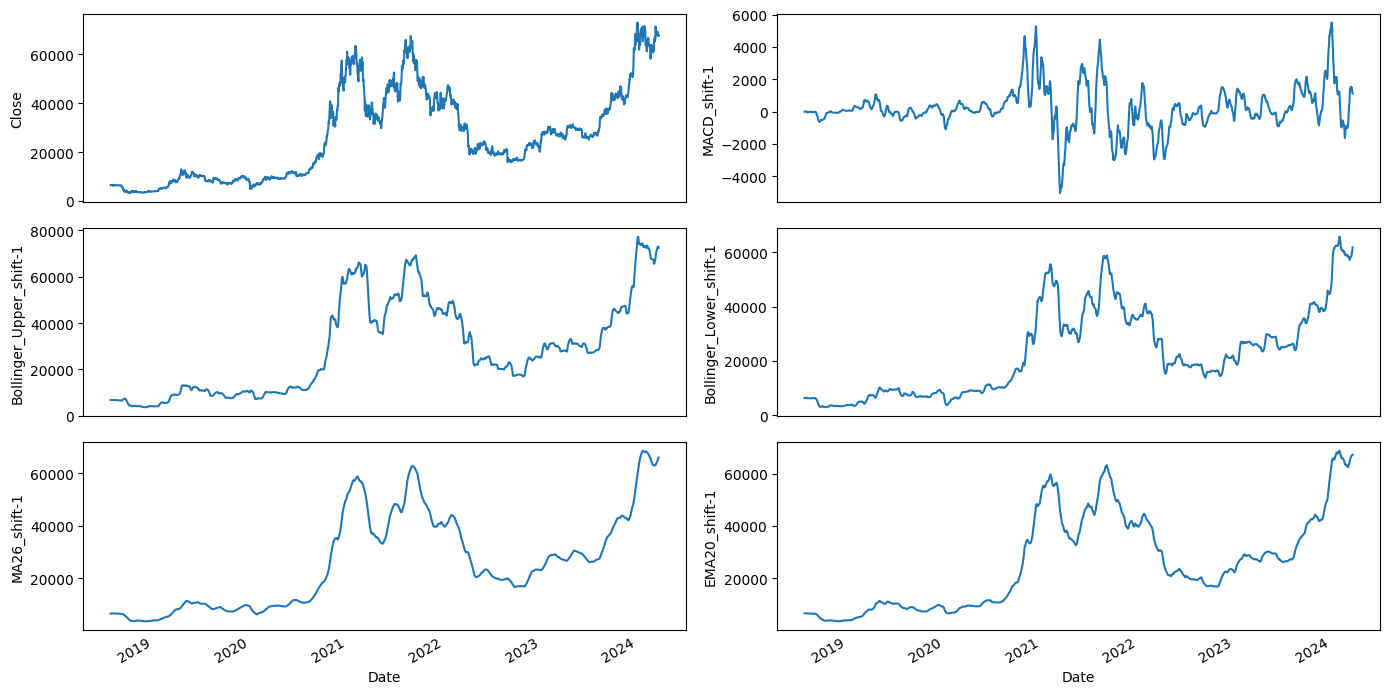

In [35]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

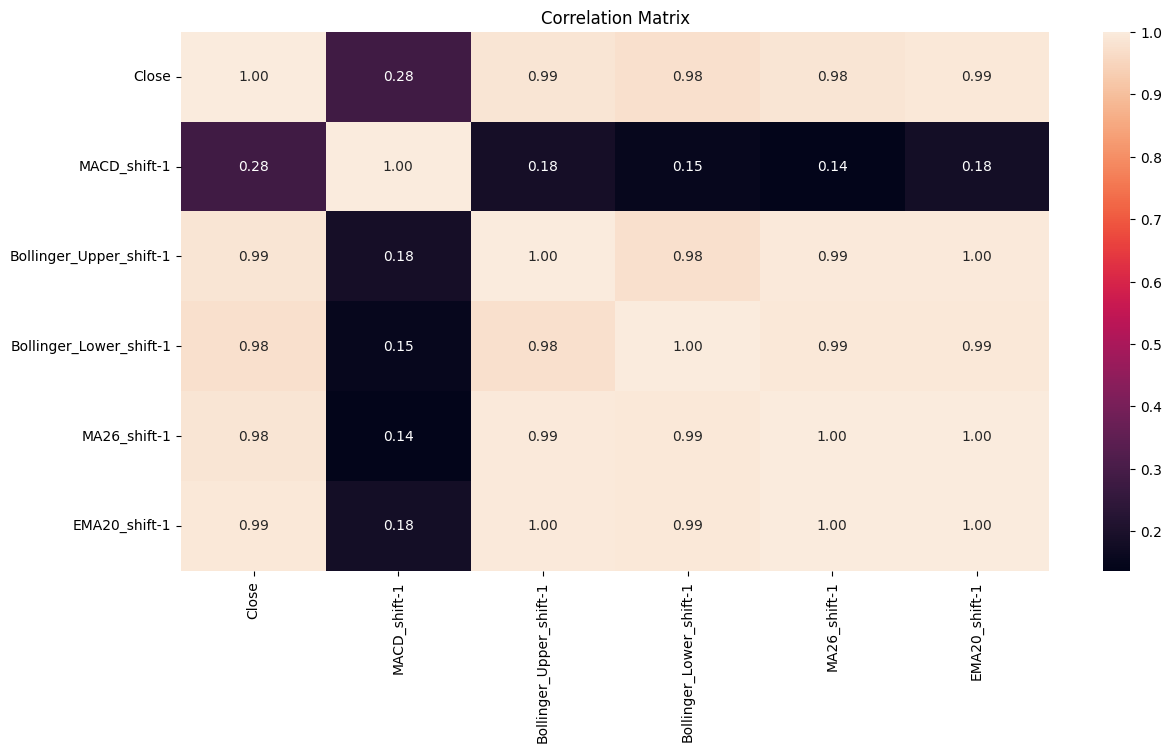

In [36]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



# Step #4: Train & Test split

In [37]:
# Train-Test Split
def split_data(df, test_size=None):
    test_size = 0.2 if test_size is None else test_size
    split_row = len(df) - int(test_size * len(df))
    train_set = df.iloc[:split_row].copy()
    test_set = df.iloc[split_row:].copy()
    return train_set, test_set

train, test = split_data(df_filtered, test_size=0.3) 

In [38]:
print(df_filtered.shape)
print(train.shape)
print(test.shape)

(2069, 6)
(1449, 6)
(620, 6)


# Step #5: Model Specification

**Linear Regression**

**1. Fitting Model**

In [39]:
# Define the target variable
target = 'Close'
X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

# OLS Model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          9.912e+04
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                        0.00
Time:                        17:02:39   Log-Likelihood:                         -12718.
No. Observations:                1449   AIC:                                  2.545e+04
Df Residuals:                    1444   BIC:                                  2.547e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

**2. Forecasting**

In [40]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        future_exog_1 = df_forecast.iloc[-1].drop('Close').copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.predict(future_exog_1)
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        future_exog_1['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([future_exog_1], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]
    

In [41]:
# Forecast next 30 days
forecast_next_30_days = forecast_next_x_days(df_original, 30, model)

# Forecast next 60 days
forecast_next_60_days = forecast_next_x_days(df_original, 60, model)

# Forecast next 90 days
forecast_next_90_days = forecast_next_x_days(df_original, 90, model)

Forecasting for day 30
Forecasting for day 1
Forecasted value for day 1: 66761.75010547298
Forecasting for day 2
Forecasted value for day 2: 66107.5242242209
Forecasting for day 3
Forecasted value for day 3: 65180.899161954876
Forecasting for day 4
Forecasted value for day 4: 64620.6739709207
Forecasting for day 5
Forecasted value for day 5: 64010.866478042866
Forecasting for day 6
Forecasted value for day 6: 63578.311473653856
Forecasting for day 7
Forecasted value for day 7: 63132.58327218609
Forecasting for day 8
Forecasted value for day 8: 62581.51889134986
Forecasting for day 9
Forecasted value for day 9: 62546.31976752356
Forecasting for day 10
Forecasted value for day 10: 62337.364548686455
Forecasting for day 11
Forecasted value for day 11: 62149.80947934925
Forecasting for day 12
Forecasted value for day 12: 61845.68896545291
Forecasting for day 13
Forecasted value for day 13: 61623.05256499039
Forecasting for day 14
Forecasted value for day 14: 61530.82145228582
Forecasting f

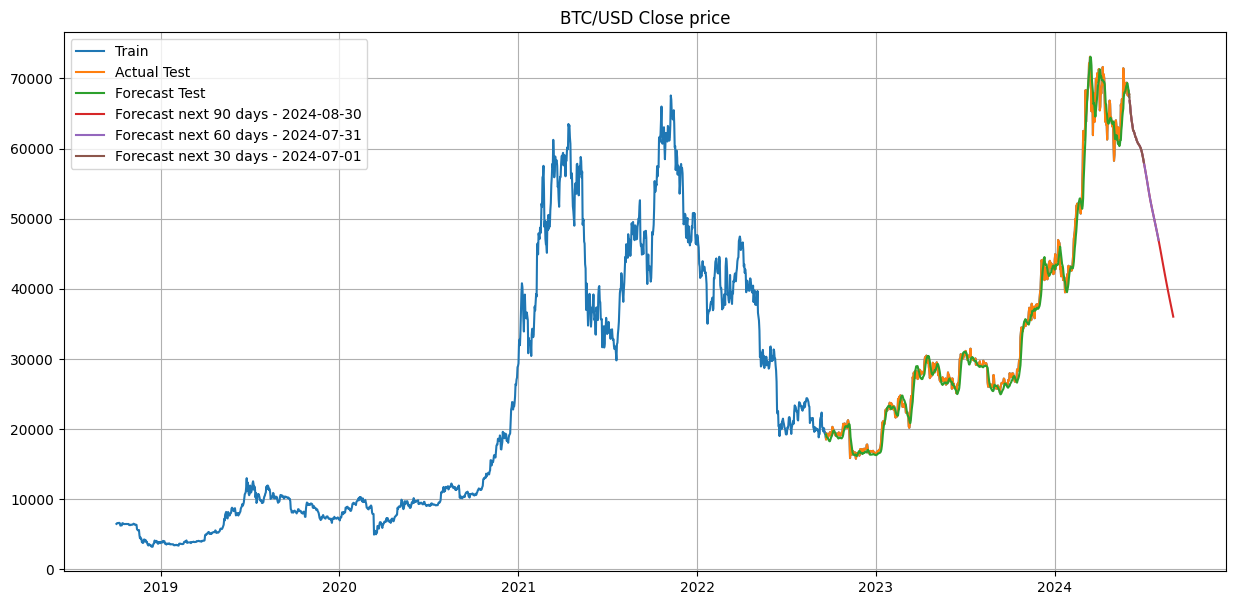

In [42]:
# Forecasting on validation set and test set
forecast_test = model.predict(X_test)

df_forecast_90 = forecast_next_90_days.copy()
df_forecast_90.index = pd.date_range(start=df_filtered.index.max(
) + dt.timedelta(days=1), periods=len(df_forecast_90))

df_forecast_60 = forecast_next_60_days.copy()
df_forecast_60.index = pd.date_range(start=df_filtered.index.max(
) + dt.timedelta(days=1), periods=len(df_forecast_60))

df_forecast_30 = forecast_next_30_days.copy()
df_forecast_30.index = pd.date_range(start=df_filtered.index.max(
) + dt.timedelta(days=1), periods=len(df_forecast_30))

# Label the forecasted data
forecast_30_label = f"Forecast next 30 days - " + \
    df_forecast_30.index[-1].strftime("%Y-%m-%d")
forecast_60_label = f"Forecast next 60 days - " + \
    df_forecast_60.index[-1].strftime("%Y-%m-%d")
forecast_90_label = f"Forecast next 90 days - " + \
    df_forecast_90.index[-1].strftime("%Y-%m-%d")

# Add last day of original data to the forecasted data
df_forecast_30 = pd.concat([df_filtered.tail(1), df_forecast_30])
df_forecast_30.index = pd.date_range(
    start=df_filtered.index.max(), periods=len(df_forecast_30))

# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Actual Test')
plt.plot(forecast_test.index, forecast_test, label='Forecast Test')
plt.plot(df_forecast_90.index,
         df_forecast_90['Close'], label=forecast_90_label)
plt.plot(df_forecast_60.index,
         df_forecast_60['Close'], label=forecast_60_label)
plt.plot(df_forecast_30.index,
         df_forecast_30['Close'], label=forecast_30_label)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

# Step #6: Model Evaluation

In [43]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate the metrics
rmse, mape, smape = calculate_metrics(test['Close'], forecast_test)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")


RMSE: 1486.62
MAPE: 2.88
SMAPE: 2.91
